In [1]:
import json
from sae_lens import SAE, HookedSAETransformer
from transformer_lens import HookedTransformer
from functools import partial
import einops
import os
import gc
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from datasets import load_dataset
from transformers import AutoTokenizer
from transformer_lens.hook_points import (
    HookPoint,
)
import numpy as np
import pandas as pd
from pprint import pprint as pp
from typing import Tuple
from torch import Tensor
from functools import lru_cache
from typing import TypedDict, Optional, Tuple, Union
from tqdm import tqdm
import random
from utils import *

In IPython
Set autoreload


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
hf_cache = os.environ.get("HF_HOME", None)
print(f"Using Hugging Face cache directory: {hf_cache}")

Using device: cuda
Using Hugging Face cache directory: /work/pi_jensen_umass_edu/svaidyanatha_umass_edu/huggingface


In [3]:
# Load the model
model_name = "google/gemma-2-2b"  # Replace with the desired model name
print(f"Loading model: {model_name}...")
model = HookedSAETransformer.from_pretrained(model_name, device=device, cache_dir=hf_cache)

Loading model: google/gemma-2-2b...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer


In [4]:
import json

# Change dir
os.chdir("/work/pi_jensen_umass_edu/svaidyanatha_umass_edu/projects/feature-multiplicity")
print(f"Current working directory: {os.getcwd()}")

# Load IOI datasets
eng_ioi_dataset = json.load(open("./data/ioi/eng_ioi.json"))
spa_ioi_dataset = json.load(open("./data/ioi/esp_ioi.json"))
fra_ioi_dataset = json.load(open("./data/ioi/fra_ioi.json"))
# deu_ioi_dataset = json.load(open("./data/ioi/deu_ioi.json"))
datasets = {
    "English": eng_ioi_dataset,
    "Spanish": spa_ioi_dataset,
    "French": fra_ioi_dataset,
    # "German": deu_ioi_dataset,
}

Current working directory: /work/pi_jensen_umass_edu/svaidyanatha_umass_edu/projects/feature-multiplicity


In [5]:
languages = datasets.keys()
data_batches = {lang: {"prompts": [], "answers": []} for lang in languages}
n_samples = 50
seed = 42
random.seed(seed)

def generate_batches(model, datasets, languages, n_samples):
    prompt_idxs = list(range(len(datasets["English"])))
    random.shuffle(prompt_idxs)

    for lang in languages:
        prompts = [item["clean_prefix"] for item in datasets[lang]]
        answers = [item["clean_answer"] for item in datasets[lang]]
        patch_answers = [item["patch_answer"] for item in datasets[lang]]
        # Find the set of prompt lengths and counts for each prompt length
        prompt_lengths = list(set([len(model.to_tokens(p)[0]) for p in prompts]))
        counts = [len([p for p in prompts if len(model.to_tokens(p)[0]) == l]) for l in prompt_lengths]
        # Pick the most frequently occurring length
        assert max(counts) >= n_samples, f"Cannot produce dataset of size {n_samples} with fixed prompt length"
        fixed_len = prompt_lengths[np.argmax(counts)]
        
        sampled_prompt_idxs = [i for i in prompt_idxs if len(model.to_tokens(prompts[i])[0]) == fixed_len]
        data_batches[lang] = {"prompts": [prompts[i] for i in sampled_prompt_idxs[:n_samples]], 
                            "answers": [answers[i] for i in sampled_prompt_idxs[:n_samples]], 
                            "patch_answers": [patch_answers[i] for i in sampled_prompt_idxs[:n_samples]]
                            }

In [6]:
# Store a few important token positions, we will use this later

def get_important_token_positions(data_batches):
    important_token_positions = {lang: {"S1": [], "IO": [], "S2": [], "PLACE": [], "OBJECT": [], "END": -1} for lang in data_batches.keys()}
    for lang in data_batches.keys():
        for i, prompt in enumerate(data_batches[lang]["prompts"]):

            encoded_tokens = model.to_tokens(prompt)[0]
            # Decode each token
            tokens = [model.to_string(t) for t in encoded_tokens]
            answers = data_batches[lang]["answers"]
            patch_answers = data_batches[lang]["patch_answers"]

            s_tokens = [f"{patch_answers[i]}", f" {patch_answers[i]}"]
            s_token_positions = [i for i, t in enumerate(tokens) if t in s_tokens]
            assert(len(s_token_positions) == 2)

            important_token_positions[lang]["S1"].append(s_token_positions[0])
            important_token_positions[lang]["S2"].append(s_token_positions[1])

            io_tokens = [f"{answers[i]}", f" {answers[i]}"]
            io_token_positions = [i for i, t in enumerate(tokens) if t in io_tokens]
            assert(len(io_token_positions) == 1)
            important_token_positions[lang]["IO"].append(io_token_positions[0])

    return important_token_positions

important_token_positions = get_important_token_positions(data_batches)

In [7]:
# Try to generate batches, if for any language and important token we have more than one unique value, we will regenerate the batches
regen = True

while regen:
    regen = False
    generate_batches(model, datasets, languages, n_samples)
    important_token_positions = get_important_token_positions(data_batches)
    for lang in languages:
        for token in important_token_positions[lang].keys():
            if token == "END":
                continue
            if len(set(important_token_positions[lang][token])) > 1:
                print(f"Regenerating batches for {lang} due to multiple values for {token}")
                regen = True
                break
        if regen:
            break

# Replace the lists in important_token_positions with the unique values
for lang in languages:
    for token in important_token_positions[lang].keys():
        if token == "END":
            continue
        if len(important_token_positions[lang][token]) > 0:
            important_token_positions[lang][token] = important_token_positions[lang][token][0]
        else:
            important_token_positions[lang][token] = 0

print("Important token positions:")
pp(important_token_positions)
    

Regenerating batches for Spanish due to multiple values for S2
Regenerating batches for Spanish due to multiple values for S2
Important token positions:
{'English': {'END': -1, 'IO': 5, 'OBJECT': 0, 'PLACE': 0, 'S1': 3, 'S2': 11},
 'French': {'END': -1, 'IO': 5, 'OBJECT': 0, 'PLACE': 0, 'S1': 3, 'S2': 12},
 'Spanish': {'END': -1, 'IO': 5, 'OBJECT': 0, 'PLACE': 0, 'S1': 3, 'S2': 11}}


In [8]:
# Test performance of SAE on the same task

from transformer_lens.utils import test_prompt

layer = 10

sae, cfg_dict, sparsity = SAE.from_pretrained(
    release="gemma-scope-2b-pt-res-canonical",
    sae_id=f"layer_{layer}/width_16k/canonical",
    device=str(device),
)

for lang, dataset in datasets.items():
    print(f"Language: {lang}")

    prompt = dataset[0]["clean_prefix"]
    answer = dataset[0]["clean_answer"]

    # First see how the model does without SAEs
    test_prompt(prompt, answer, model)

    # Test our prompt, to see what the model says
    with model.saes(saes=[sae]):
        test_prompt(prompt, answer, model)

    # Same thing, done in a different way
    model.add_sae(sae)
    test_prompt(prompt, answer, model)
    model.reset_saes()  # Remember to always do this!

    # Using `run_with_saes` method in place of standard forward pass
    logits = model(prompt, return_type="logits")
    logits_sae = model.run_with_saes(prompt, saes=[sae], return_type="logits")
    answer_token_id = model.to_single_token(answer)

    # Getting model's prediction
    top_prob, token_id_prediction = logits[0, -1].softmax(-1).max(-1)
    top_prob_sae, token_id_prediction_sae = logits_sae[0, -1].softmax(-1).max(-1)

    print(f"""Standard model: top prediction = {model.to_string(token_id_prediction)!r}, prob = {top_prob.item():.2%}
    SAE reconstruction: top prediction = {model.to_string(token_id_prediction_sae)!r}, prob = {top_prob_sae.item():.2%}
    """)
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------------")

Language: English
Tokenized prompt: ['<bos>', 'Then', ',', ' Richard', ' and', ' Erica', ' went', ' to', ' the', ' hospital', '.', ' Richard', ' gave', ' a', ' drink', ' to']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 0        Logit: 27.83 Prob: 48.86% Token: | Erica|

Top 0th token. Logit: 27.83 Prob: 48.86% Token: | Erica|
Top 1th token. Logit: 27.13 Prob: 24.31% Token: | the|
Top 2th token. Logit: 25.85 Prob:  6.74% Token: | his|
Top 3th token. Logit: 25.82 Prob:  6.55% Token: | a|
Top 4th token. Logit: 24.17 Prob:  1.26% Token: | Dr|
Top 5th token. Logit: 24.15 Prob:  1.23% Token: | her|
Top 6th token. Logit: 23.89 Prob:  0.95% Token: | an|
Top 7th token. Logit: 23.07 Prob:  0.42% Token: | him|
Top 8th token. Logit: 23.04 Prob:  0.41% Token: | Eric|
Top 9th token. Logit: 22.90 Prob:  0.35% Token: | nurse|


Ranks of the answer tokens: [(' Erica', 0)]

Tokenized prompt: ['<bos>', 'Then', ',', ' Richard', ' and', ' Erica', ' went', ' to', ' the', ' hospital', '.', ' Richard', ' gave', ' a', ' drink', ' to']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 0        Logit: 27.83 Prob: 52.12% Token: | Erica|

Top 0th token. Logit: 27.83 Prob: 52.12% Token: | Erica|
Top 1th token. Logit: 26.84 Prob: 19.29% Token: | the|
Top 2th token. Logit: 26.21 Prob: 10.31% Token: | Richard|
Top 3th token. Logit: 25.57 Prob:  5.42% Token: | his|
Top 4th token. Logit: 25.18 Prob:  3.68% Token: | a|
Top 5th token. Logit: 24.10 Prob:  1.24% Token: | him|
Top 6th token. Logit: 23.93 Prob:  1.05% Token: | her|
Top 7th token. Logit: 23.19 Prob:  0.50% Token: | an|
Top 8th token. Logit: 22.84 Prob:  0.35% Token: | himself|
Top 9th token. Logit: 22.80 Prob:  0.34% Token: | each|


Ranks of the answer tokens: [(' Erica', 0)]

Tokenized prompt: ['<bos>', 'Then', ',', ' Richard', ' and', ' Erica', ' went', ' to', ' the', ' hospital', '.', ' Richard', ' gave', ' a', ' drink', ' to']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 0        Logit: 27.83 Prob: 52.12% Token: | Erica|

Top 0th token. Logit: 27.83 Prob: 52.12% Token: | Erica|
Top 1th token. Logit: 26.84 Prob: 19.29% Token: | the|
Top 2th token. Logit: 26.21 Prob: 10.31% Token: | Richard|
Top 3th token. Logit: 25.57 Prob:  5.42% Token: | his|
Top 4th token. Logit: 25.18 Prob:  3.68% Token: | a|
Top 5th token. Logit: 24.10 Prob:  1.24% Token: | him|
Top 6th token. Logit: 23.93 Prob:  1.05% Token: | her|
Top 7th token. Logit: 23.19 Prob:  0.50% Token: | an|
Top 8th token. Logit: 22.84 Prob:  0.35% Token: | himself|
Top 9th token. Logit: 22.80 Prob:  0.34% Token: | each|


Ranks of the answer tokens: [(' Erica', 0)]

Standard model: top prediction = ' Erica', prob = 48.86%
    SAE reconstruction: top prediction = ' Erica', prob = 52.12%
    
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Language: Spanish
Tokenized prompt: ['<bos>', 'Luego', ',', ' Richard', ' y', ' Erica', ' fueron', ' al', ' hospital', '.', ' Richard', ' le', ' dio', ' una', ' bebida', ' a']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 0        Logit: 26.50 Prob: 54.37% Token: | Erica|

Top 0th token. Logit: 26.50 Prob: 54.37% Token: | Erica|
Top 1th token. Logit: 25.21 Prob: 15.00% Token: | su|
Top 2th token. Logit: 24.77 Prob:  9.68% Token: | la|
Top 3th token. Logit: 23.19 Prob:  1.99% Token: | un|
Top 4th token. Logit: 22.74 Prob:  1.27% Token: | una|
Top 5th token. Logit: 22.72 Prob:  1.24% Token: | los|
Top 6th token. Logit: 22.63 Prob:  1.13% Token: | Eric|
Top 7th token. Logit: 22.51 Prob:  1.00% Token: | Richard|
Top 8th token. Logit: 22.21 Prob:  0.75% Token: | sus|
Top 9th token. Logit: 21.55 Prob:  0.39% Token: | ella|


Ranks of the answer tokens: [(' Erica', 0)]

Tokenized prompt: ['<bos>', 'Luego', ',', ' Richard', ' y', ' Erica', ' fueron', ' al', ' hospital', '.', ' Richard', ' le', ' dio', ' una', ' bebida', ' a']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 1        Logit: 23.82 Prob: 19.08% Token: | Erica|

Top 0th token. Logit: 24.74 Prob: 47.67% Token: | Richard|
Top 1th token. Logit: 23.82 Prob: 19.08% Token: | Erica|
Top 2th token. Logit: 23.24 Prob: 10.63% Token: | la|
Top 3th token. Logit: 22.58 Prob:  5.53% Token: | su|
Top 4th token. Logit: 21.10 Prob:  1.25% Token: | los|
Top 5th token. Logit: 20.95 Prob:  1.09% Token: | las|
Top 6th token. Logit: 20.32 Prob:  0.57% Token: | un|
Top 7th token. Logit: 20.18 Prob:  0.50% Token: | una|
Top 8th token. Logit: 19.74 Prob:  0.32% Token: | Becker|
Top 9th token. Logit: 19.36 Prob:  0.22% Token: |́|


Ranks of the answer tokens: [(' Erica', 1)]

Tokenized prompt: ['<bos>', 'Luego', ',', ' Richard', ' y', ' Erica', ' fueron', ' al', ' hospital', '.', ' Richard', ' le', ' dio', ' una', ' bebida', ' a']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 1        Logit: 23.82 Prob: 19.08% Token: | Erica|

Top 0th token. Logit: 24.74 Prob: 47.67% Token: | Richard|
Top 1th token. Logit: 23.82 Prob: 19.08% Token: | Erica|
Top 2th token. Logit: 23.24 Prob: 10.63% Token: | la|
Top 3th token. Logit: 22.58 Prob:  5.53% Token: | su|
Top 4th token. Logit: 21.10 Prob:  1.25% Token: | los|
Top 5th token. Logit: 20.95 Prob:  1.09% Token: | las|
Top 6th token. Logit: 20.32 Prob:  0.57% Token: | un|
Top 7th token. Logit: 20.18 Prob:  0.50% Token: | una|
Top 8th token. Logit: 19.74 Prob:  0.32% Token: | Becker|
Top 9th token. Logit: 19.36 Prob:  0.22% Token: |́|


Ranks of the answer tokens: [(' Erica', 1)]

Standard model: top prediction = ' Erica', prob = 54.37%
    SAE reconstruction: top prediction = ' Richard', prob = 47.67%
    
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Language: French
Tokenized prompt: ['<bos>', 'Ensuite', ',', ' Richard', ' et', ' Erica', ' sont', ' all', 'és', ' à', ' l', "'", 'hôpital', '.', ' Richard', ' a', ' donné', ' une', ' boisson', ' à']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 0        Logit: 27.41 Prob: 72.81% Token: | Erica|

Top 0th token. Logit: 27.41 Prob: 72.81% Token: | Erica|
Top 1th token. Logit: 25.05 Prob:  6.88% Token: | son|
Top 2th token. Logit: 24.32 Prob:  3.31% Token: | l|
Top 3th token. Logit: 24.24 Prob:  3.06% Token: | la|
Top 4th token. Logit: 24.04 Prob:  2.50% Token: | sa|
Top 5th token. Logit: 23.75 Prob:  1.88% Token: | un|
Top 6th token. Logit: 23.43 Prob:  1.36% Token: |Erica|
Top 7th token. Logit: 23.04 Prob:  0.92% Token: | une|
Top 8th token. Logit: 22.59 Prob:  0.59% Token: | Eric|
Top 9th token. Logit: 21.89 Prob:  0.29% Token: | É|


Ranks of the answer tokens: [(' Erica', 0)]

Tokenized prompt: ['<bos>', 'Ensuite', ',', ' Richard', ' et', ' Erica', ' sont', ' all', 'és', ' à', ' l', "'", 'hôpital', '.', ' Richard', ' a', ' donné', ' une', ' boisson', ' à']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 0        Logit: 26.21 Prob: 72.70% Token: | Erica|

Top 0th token. Logit: 26.21 Prob: 72.70% Token: | Erica|
Top 1th token. Logit: 23.67 Prob:  5.76% Token: | Richard|
Top 2th token. Logit: 23.56 Prob:  5.12% Token: | l|
Top 3th token. Logit: 23.31 Prob:  4.01% Token: | la|
Top 4th token. Logit: 22.63 Prob:  2.02% Token: | son|
Top 5th token. Logit: 22.46 Prob:  1.71% Token: | sa|
Top 6th token. Logit: 22.26 Prob:  1.40% Token: | un|
Top 7th token. Logit: 21.59 Prob:  0.71% Token: | une|
Top 8th token. Logit: 21.25 Prob:  0.51% Token: |Erica|
Top 9th token. Logit: 21.02 Prob:  0.40% Token: | ses|


Ranks of the answer tokens: [(' Erica', 0)]

Tokenized prompt: ['<bos>', 'Ensuite', ',', ' Richard', ' et', ' Erica', ' sont', ' all', 'és', ' à', ' l', "'", 'hôpital', '.', ' Richard', ' a', ' donné', ' une', ' boisson', ' à']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 0        Logit: 26.21 Prob: 72.70% Token: | Erica|

Top 0th token. Logit: 26.21 Prob: 72.70% Token: | Erica|
Top 1th token. Logit: 23.67 Prob:  5.76% Token: | Richard|
Top 2th token. Logit: 23.56 Prob:  5.12% Token: | l|
Top 3th token. Logit: 23.31 Prob:  4.01% Token: | la|
Top 4th token. Logit: 22.63 Prob:  2.02% Token: | son|
Top 5th token. Logit: 22.46 Prob:  1.71% Token: | sa|
Top 6th token. Logit: 22.26 Prob:  1.40% Token: | un|
Top 7th token. Logit: 21.59 Prob:  0.71% Token: | une|
Top 8th token. Logit: 21.25 Prob:  0.51% Token: |Erica|
Top 9th token. Logit: 21.02 Prob:  0.40% Token: | ses|


Ranks of the answer tokens: [(' Erica', 0)]

Standard model: top prediction = ' Erica', prob = 72.81%
    SAE reconstruction: top prediction = ' Erica', prob = 72.70%
    
-------------------------------------------------------------------------------------------------------------------------------------------------------------


In [9]:
from IPython.display import IFrame, display
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory

def display_dashboard(
    sae_release="gemma-scope-2b-pt-res-canonical",
    sae_id="layer_10/width_16k/canonical",
    latent_idx=0,
    width=800,
    height=600,
):
    release = get_pretrained_saes_directory()[sae_release]
    neuronpedia_id = release.neuronpedia_id[sae_id]

    url = f"https://neuronpedia.org/{neuronpedia_id}/{latent_idx}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

    print(url)
    display(IFrame(url, width=width, height=height))

### Attribution Patching with Integrated Gradients

In [10]:
from utils import *
from torch.nn import functional as F

def get_zero_atp_ig_effect(model, saes, sae_idx, toks, labels, ig_steps):
    with torch.no_grad():
        _, saes = run_sae_hook_fn(model, saes, toks, cache_sae_activations=True)
        clean_acts = [s.feature_acts for s in saes]
        cleanup_cuda()   
    sae_clean_acts = clean_acts[sae_idx]
    sae_corr_acts = torch.zeros_like(sae_clean_acts)

    ratios = [i/ig_steps for i in range(ig_steps)]
    effects = []
    for ratio in tqdm(ratios): 
        # get interpolated activations and logits between clean and zero 
        interpolation = (sae_clean_acts * (1-ratio) + sae_corr_acts * (ratio)).requires_grad_(True)
        interpolation.retain_grad()
        interpolated_out, saes = run_sae_hook_fn(model, saes, toks, fake_activations=(saes[sae_idx].cfg.hook_layer,interpolation))

        # metric is prob of correct tok
        answer_logits = interpolated_out[..., -1, :]
        answer_logprobs = F.softmax(answer_logits, dim=-1)
        clean_logprobs = answer_logprobs[..., torch.arange(answer_logprobs.shape[-2]), labels]
        metric = torch.sum(clean_logprobs)
        metric.backward()

        # attr formula
        counterfactual_delta = sae_clean_acts - sae_corr_acts
        effect = (interpolation.grad * counterfactual_delta).mean(dim=0)
        effects.append(effect)
        cleanup_cuda()

    effects = torch.stack(effects)
    clear_memory(saes, model)
    final_effect = effects.mean(dim=0)
    return model, saes, final_effect

In [11]:
# Run attribution patching

def run_attribution_patching(data_batches, model, sae):
    causal_effects = {}
    cleanup_cuda()

    for lang in data_batches.keys():
        saes = [sae]
        sae_idx = 0
        ig_steps = 10
        toks = model.to_tokens(data_batches[lang]["prompts"])
        answers = data_batches[lang]["answers"]
        labels = torch.Tensor([model.to_single_token(answer) for answer in answers]).int().to(device)

        model, saes, effect = get_zero_atp_ig_effect(model, saes, sae_idx, toks, labels, ig_steps)
        causal_effects[lang] = effect.cpu().numpy()
        print(f"AtP-IG done for {lang}: shape is {causal_effects[lang].shape}")
    return causal_effects

causal_effects = run_attribution_patching(data_batches, model, sae)

100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


AtP-IG done for English: shape is (16, 16384)


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


AtP-IG done for Spanish: shape is (17, 16384)


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]

AtP-IG done for French: shape is (18, 16384)


Number of latents for English with absolute AtP-IG score > 0.005: 75
Number of latents for Spanish with absolute AtP-IG score > 0.005: 103
Number of latents for French with absolute AtP-IG score > 0.005: 89


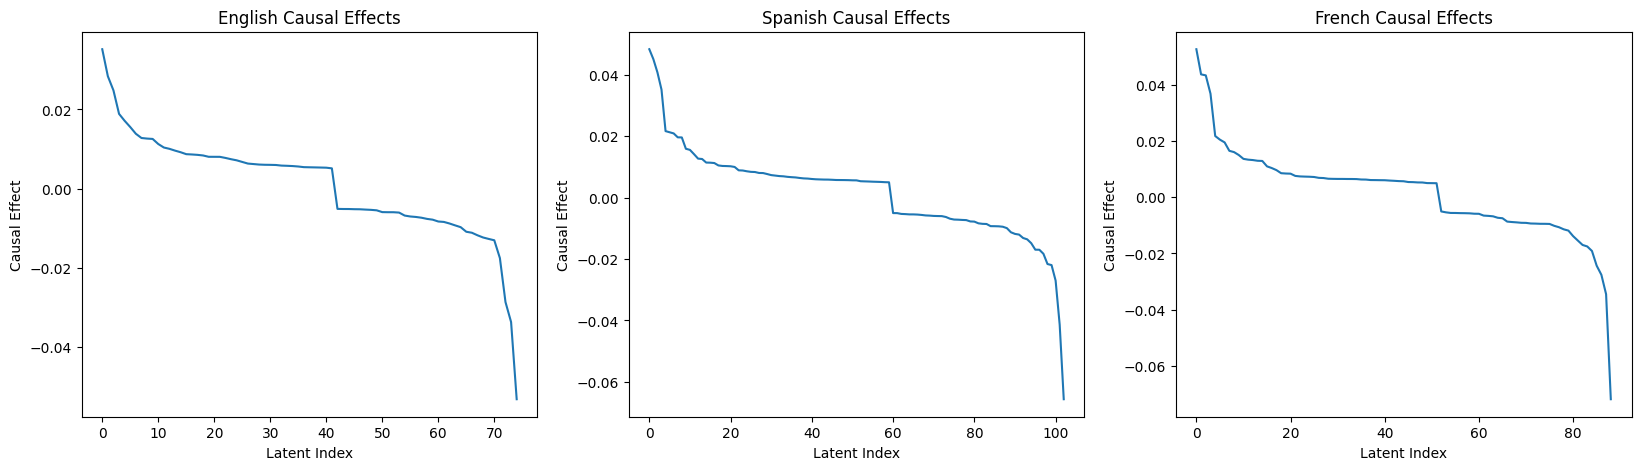

In [12]:
threshold = 5e-3

def threshold_causal_effects(causal_effects, threshold):
    relevant_latents = {}
    for lang in languages:
        # Get list of (x, y) indices of latents in the (17, 16384) tensor that are above the threshold
        relevant_latents[lang] = np.argwhere(np.abs(causal_effects[lang]) > threshold)
        # Sort by attribution score
        relevant_latents[lang] = sorted(relevant_latents[lang], key=lambda x: causal_effects[lang][x[0], x[1]], reverse=True)
        # Get 3D tensor of latents and attribution scores
        relevant_latents[lang] = np.array([(x, y, causal_effects[lang][x, y]) for x, y in relevant_latents[lang]])
    return relevant_latents

# Plot causal effects for every language
relevant_latents = threshold_causal_effects(causal_effects, threshold)
for lang in languages:
    print(f"Number of latents for {lang} with absolute AtP-IG score > {threshold}: {len(relevant_latents[lang])}")

fig, axs = plt.subplots(1, len(languages), figsize=(20, 5))
for i, lang in enumerate(languages):
    axs[i].plot(relevant_latents[lang][:, -1])
    axs[i].set_title(f"{lang} Causal Effects")
    axs[i].set_xlabel("Latent Index")
    axs[i].set_ylabel("Causal Effect")


In [13]:
# Get the top  latents for each language, determined by the "knee" in the plot where there is a significant change in the causal effect
# Do this separately for positive and negative causal effect
from kneed import KneeLocator

def get_knee_points(relevant_latents, lang):

    top_latents = {}
    for lang in languages:
        
        # Separate positive and negative effects
        pos_latents = relevant_latents[lang][relevant_latents[lang][:, -1] > 0]
        neg_latents = relevant_latents[lang][relevant_latents[lang][:, -1] < 0]

        # Sort negative latents by decreasing absolute value of causal effect
        neg_latents = neg_latents[np.argsort(np.abs(neg_latents[:, -1]))[::-1]]

        # Find the "knee" point for positive and negative separately
        if len(pos_latents) > 1:
            knee_pos = KneeLocator(range(len(pos_latents)), pos_latents[:, -1], curve='convex', direction='decreasing')
            k_pos = knee_pos.knee if knee_pos.knee is not None else len(pos_latents)
        else:
            k_pos = len(pos_latents)

        if len(neg_latents) > 1:
            abs_neg_latents = np.abs(neg_latents)
            knee_neg = KneeLocator(range(len(abs_neg_latents)), abs_neg_latents[:, -1], curve='convex', direction='decreasing')
            k_neg = knee_neg.knee if knee_neg.knee is not None else len(abs_neg_latents)
        else:
            k_neg = len(abs_neg_latents)

        # Store top latents
        top_latents[lang] = {
            "positive": pos_latents[:k_pos],
            "negative": neg_latents[:k_neg]
        }

    return top_latents

top_latents = get_knee_points(relevant_latents, languages)
for lang in languages:
    len_pos = len(top_latents[lang]["positive"])
    len_neg = len(top_latents[lang]["negative"])
    print(f"Selected top {len_pos} positive latents and {len_neg} negative latents for {lang}")

Selected top 7 positive latents and 4 negative latents for English
Selected top 14 positive latents and 5 negative latents for Spanish
Selected top 10 positive latents and 4 negative latents for French


In [14]:
# Print out the top latents for each language

def get_top_latent_ids(top_latents, lang):
    pos_tuple_list = [(int(x), int(y)) for x, y, _ in top_latents[lang]["positive"]]
    neg_tuple_list = [(int(x), int(y)) for x, y, _ in top_latents[lang]["negative"]]
    return pos_tuple_list, neg_tuple_list

for lang in languages:
    print(f"Top positive latents for {lang}: {get_top_latent_ids(top_latents, lang)[0]}")
    print(f"Top negative latents for {lang}: {get_top_latent_ids(top_latents, lang)[1]}")
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------------")

Top positive latents for English: [(5, 2592), (11, 12968), (5, 14660), (9, 3986), (11, 6876), (3, 388), (15, 9785)]
Top negative latents for English: [(5, 388), (11, 3986), (5, 3986), (9, 1205)]
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Top positive latents for Spanish: [(16, 8383), (11, 12968), (5, 14660), (5, 2592), (11, 6876), (4, 3986), (3, 3986), (3, 388), (11, 13400), (7, 14305), (9, 3986), (1, 3986), (16, 1584), (6, 14305)]
Top negative latents for Spanish: [(5, 388), (11, 3986), (5, 3986), (5, 6319), (1, 4392)]
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Top positive latents for French: [(17, 8383), (5, 14660), (12, 12968), (5, 2592), (14, 1503), (12, 6876), (3, 3986), (12, 13400), (4, 3986), (1, 3986)]
Top negative latents for French: [(5, 388), (12, 

# Searching for reused latents

In [15]:
def compute_latent_overlaps(top_latents):

    results = {}
    languages = list(top_latents.keys())
    # Pairwise
    for i in range(len(languages)):
        for j in range(i + 1, len(languages)):
            lang_A = languages[i]
            lang_B = languages[j]
            
            pos_A, neg_A = get_top_latent_ids(top_latents, lang_A)
            pos_B, neg_B = get_top_latent_ids(top_latents, lang_B)
            
            overlap_pos = set(pos_A) & set(pos_B)
            overlap_neg = set(neg_A) & set(neg_B)
            
            results[(lang_A, lang_B)] = {
                "positive": overlap_pos,
                "negative": overlap_neg
            }
    
    # Intersection across all languages
    pos_sets = []
    neg_sets = []
    for lang in languages:
        pos_s, neg_s = get_top_latent_ids(top_latents, lang)
        pos_sets.append(set(pos_s))
        neg_sets.append(set(neg_s))
    
    # Latents common to all languages (intersection of sets)
    all_pos = set.intersection(*pos_sets) if len(pos_sets) > 1 else pos_sets[0]
    all_neg = set.intersection(*neg_sets) if len(neg_sets) > 1 else neg_sets[0]

    all_common = {
        "positive": all_pos,
        "negative": all_neg
    }
    
    return results, all_common

# Compute the Intersection over Union (IoU) for the top latents
def compute_iou(overlaps, all_common):
    iou = {}
    for (lang_A, lang_B), data in overlaps.items():
        pos_A, neg_A = get_top_latent_ids(top_latents, lang_A)
        pos_B, neg_B = get_top_latent_ids(top_latents, lang_B)
        
        union_pos = set(pos_A) | set(pos_B)
        union_neg = set(neg_A) | set(neg_B)
        
        iou_pos = len(data["positive"]) / len(union_pos)
        iou_neg = len(data["negative"]) / len(union_neg)
        iou_total = (len(data["positive"]) + len(data["negative"])) / (len(union_pos) + len(union_neg))
        
        iou[(lang_A, lang_B)] = {
            "positive": iou_pos,
            "negative": iou_neg,
            "total": iou_total
        }
    
    # IoU for latents common to all languages
    pos_sets = []
    neg_sets = []
    for lang in languages:
        pos_s, neg_s = get_top_latent_ids(top_latents, lang)
        pos_sets.append(set(pos_s))
        neg_sets.append(set(neg_s))
    
    union_pos = set.union(*pos_sets) if len(pos_sets) > 1 else pos_sets[0]
    union_neg = set.union(*neg_sets) if len(neg_sets) > 1 else neg_sets[0]
    
    iou_all = {
        "positive": len(all_common["positive"]) / len(union_pos),
        "negative": len(all_common["negative"]) / len(union_neg),
        "total": (len(all_common["positive"]) + len(all_common["negative"])) / (len(union_pos) + len(union_neg))
    }
    
    return iou, iou_all

In [16]:
def build_latent_id_sets(top_latents):
    """
    Given the original top_latents structure, returns a new dict
    that maps each language -> {"positive": set_of_latent_ids, "negative": set_of_latent_ids}.
    """
    top_latents_ids_only = {}
    for lang in top_latents:
        # get_top_latent_ids is your existing function that returns lists of (token_pos, latent_id)
        pos_list, neg_list = get_top_latent_ids(top_latents, lang)
        
        # keep only latent_id
        pos_latent_ids = {latent_id for (_, latent_id) in pos_list}
        neg_latent_ids = {latent_id for (_, latent_id) in neg_list}
        
        top_latents_ids_only[lang] = {
            "positive": pos_latent_ids,
            "negative": neg_latent_ids
        }
    return top_latents_ids_only

def compute_latent_id_overlaps(top_latents_ids_only):
    """
    Returns:
      overlaps: dict of { (langA, langB): {"positive": set_of_overlapping_ids, "negative": set_of_overlapping_ids} }
      all_common: dict of {"positive": set_of_ids_in_all_langs, "negative": set_of_ids_in_all_langs}
    """
    overlaps = {}
    languages = list(top_latents_ids_only.keys())
    
    # Pairwise
    for i in range(len(languages)):
        for j in range(i+1, len(languages)):
            langA, langB = languages[i], languages[j]
            
            posA = top_latents_ids_only[langA]["positive"]
            negA = top_latents_ids_only[langA]["negative"]
            posB = top_latents_ids_only[langB]["positive"]
            negB = top_latents_ids_only[langB]["negative"]
            
            overlap_pos = posA & posB
            overlap_neg = negA & negB
            
            overlaps[(langA, langB)] = {
                "positive": overlap_pos,
                "negative": overlap_neg
            }
    
    # Intersection across *all* languages (all-common)
    pos_sets = [top_latents_ids_only[lang]["positive"] for lang in languages]
    neg_sets = [top_latents_ids_only[lang]["negative"] for lang in languages]
    
    # intersection over all languages
    all_pos = set.intersection(*pos_sets)
    all_neg = set.intersection(*neg_sets)
    
    all_common = {
        "positive": all_pos,
        "negative": all_neg
    }
    
    return overlaps, all_common

def compute_latent_id_iou(top_latents_ids_only, overlaps_ids, all_common_ids):
    """
    For each (langA, langB) pair, compute:
      iou_pos = |overlap_pos| / |union_pos|
      iou_neg = |overlap_neg| / |union_neg|
      iou_total = (|overlap_pos|+|overlap_neg|) / (|union_pos|+|union_neg|)
    Also compute iou_all for latents common to all languages.
    """
    iou = {}
    
    languages = list(top_latents_ids_only.keys())
    for (langA, langB), data in overlaps_ids.items():
        posA = top_latents_ids_only[langA]["positive"]
        negA = top_latents_ids_only[langA]["negative"]
        posB = top_latents_ids_only[langB]["positive"]
        negB = top_latents_ids_only[langB]["negative"]
        
        union_pos = posA | posB
        union_neg = negA | negB
        
        overlap_pos = data["positive"]
        overlap_neg = data["negative"]
        
        iou_pos = len(overlap_pos) / len(union_pos) if len(union_pos) > 0 else 0
        iou_neg = len(overlap_neg) / len(union_neg) if len(union_neg) > 0 else 0
        
        denom_total = (len(union_pos) + len(union_neg))
        overlap_total = (len(overlap_pos) + len(overlap_neg))
        iou_total = overlap_total / denom_total if denom_total > 0 else 0
        
        iou[(langA, langB)] = {
            "positive": iou_pos,
            "negative": iou_neg,
            "total": iou_total
        }

    # IoU for latents common to ALL languages
    pos_sets = [top_latents_ids_only[lang]["positive"] for lang in languages]
    neg_sets = [top_latents_ids_only[lang]["negative"] for lang in languages]
    
    union_pos = set.union(*pos_sets)
    union_neg = set.union(*neg_sets)

    overlap_pos_all = all_common_ids["positive"]
    overlap_neg_all = all_common_ids["negative"]

    iou_pos_all = len(overlap_pos_all) / len(union_pos) if len(union_pos) > 0 else 0
    iou_neg_all = len(overlap_neg_all) / len(union_neg) if len(union_neg) > 0 else 0
    
    denom_total_all = (len(union_pos) + len(union_neg))
    overlap_total_all = (len(overlap_pos_all) + len(overlap_neg_all))
    iou_total_all = overlap_total_all / denom_total_all if denom_total_all > 0 else 0

    iou_all = {
        "positive": iou_pos_all,
        "negative": iou_neg_all,
        "total": iou_total_all
    }

    return iou, iou_all

# -- NEW HELPER: Pairwise Non-Intersecting Latent IDs --
def get_pairwise_non_intersecting_ids(top_latents_ids_only):
    """
    For each pair (langA, langB), returns the latent IDs in langA *not* in the intersection with langB,
    and vice versa (for both positive and negative).
    
    results[(langA, langB)] = {
      "non_intersecting_A": {
        "positive": set_of_latent_ids,
        "negative": set_of_latent_ids
      },
      "non_intersecting_B": {
        "positive": set_of_latent_ids,
        "negative": set_of_latent_ids
      }
    }
    """
    results = {}
    languages = list(top_latents_ids_only.keys())
    
    for i in range(len(languages)):
        for j in range(i+1, len(languages)):
            langA, langB = languages[i], languages[j]

            posA = top_latents_ids_only[langA]["positive"]
            negA = top_latents_ids_only[langA]["negative"]
            posB = top_latents_ids_only[langB]["positive"]
            negB = top_latents_ids_only[langB]["negative"]
            
            # Intersections
            overlap_pos = posA & posB
            overlap_neg = negA & negB
            
            # Non-intersecting from A's perspective
            nonA_pos = posA - overlap_pos
            nonA_neg = negA - overlap_neg
            
            # Non-intersecting from B's perspective
            nonB_pos = posB - overlap_pos
            nonB_neg = negB - overlap_neg
            
            results[(langA, langB)] = {
                "non_intersecting_A": {
                    "positive": nonA_pos,
                    "negative": nonA_neg
                },
                "non_intersecting_B": {
                    "positive": nonB_pos,
                    "negative": nonB_neg
                }
            }
    
    return results

# ------------------- RUN EVERYTHING -------------------
top_latents_ids_only = build_latent_id_sets(top_latents)
overlaps_ids, all_common_ids = compute_latent_id_overlaps(top_latents_ids_only)
iou_ids, iou_all_ids = compute_latent_id_iou(top_latents_ids_only, overlaps_ids, all_common_ids)
pairwise_non_intersecting = get_pairwise_non_intersecting_ids(top_latents_ids_only)

# -- Print Pairwise Overlaps --
for (langA, langB) in overlaps_ids.keys():
    # Overlap data
    overlap_data = overlaps_ids[(langA, langB)]
    # Non-intersecting data
    non_data = pairwise_non_intersecting[(langA, langB)]
    
    print(f"==================== {langA} vs. {langB} ====================")
    
    # Overlaps
    print("Overlap:")
    print(f"  Positive => {overlap_data['positive']}")
    print(f"  Negative => {overlap_data['negative']}")
    
    # Non-intersecting latents for langA
    print(f"\nNon-intersecting (in {langA} only):")
    print(f"  Positive => {non_data['non_intersecting_A']['positive']}")
    print(f"  Negative => {non_data['non_intersecting_A']['negative']}")
    
    # Non-intersecting latents for langB
    print(f"\nNon-intersecting (in {langB} only):")
    print(f"  Positive => {non_data['non_intersecting_B']['positive']}")
    print(f"  Negative => {non_data['non_intersecting_B']['negative']}")

    iou_values = iou_ids[(langA, langB)]
    print(f"IoU for {langA} & {langB}:")
    print(f"  Positive: {iou_values['positive']:.2f}")
    print(f"  Negative: {iou_values['negative']:.2f}")
    print(f"  Total: {iou_values['total']:.2f}\n")
    
    print("============================================================\n")

print("Latent IDs common to ALL languages (positive):", all_common_ids["positive"])
print("Latent IDs common to ALL languages (negative):", all_common_ids["negative"])
print(f"IoU for latents common to ALL languages:")
print(f"  Positive: {iou_all_ids['positive']:.2f}")
print(f"  Negative: {iou_all_ids['negative']:.2f}")
print(f"  Total: {iou_all_ids['total']:.2f}\n")

==================== English vs. Spanish ====================
Overlap:
  Positive => {2592, 388, 14660, 12968, 3986, 6876}
  Negative => {3986, 388}

Non-intersecting (in English only):
  Positive => {9785}
  Negative => {1205}

Non-intersecting (in Spanish only):
  Positive => {1584, 14305, 13400, 8383}
  Negative => {4392, 6319}
IoU for English & Spanish:
  Positive: 0.55
  Negative: 0.40
  Total: 0.50


==================== English vs. French ====================
Overlap:
  Positive => {2592, 14660, 12968, 3986, 6876}
  Negative => {3986, 388}

Non-intersecting (in English only):
  Positive => {9785, 388}
  Negative => {1205}

Non-intersecting (in French only):
  Positive => {13400, 1503, 8383}
  Negative => {4392}
IoU for English & French:
  Positive: 0.50
  Negative: 0.50
  Total: 0.50


==================== Spanish vs. French ====================
Overlap:
  Positive => {2592, 14660, 12968, 3986, 13400, 6876, 8383}
  Negative => {4392, 3986, 388}

Non-intersecting (in Spanish only

In [17]:
overlaps, all_common = compute_latent_overlaps(top_latents)
iou, iou_all = compute_iou(overlaps, all_common)

# Print out pairwise overlaps and IoU
for (lang_A, lang_B), data in overlaps.items():
    print(f"Overlap between {lang_A} & {lang_B}:")
    print(f"  Positive: {data['positive']}")
    print(f"  Negative: {data['negative']}")
    print(f"IoU between {lang_A} & {lang_B}:")
    print(f"  Positive: {iou[(lang_A, lang_B)]['positive']:.2f}")
    print(f"  Negative: {iou[(lang_A, lang_B)]['negative']:.2f}")
    print(f"  Total: {iou[(lang_A, lang_B)]['total']:.2f}")

    print("")

# Print out latents common to *all* languages
print("Latents common to ALL languages:")
print(f"  Positive: {all_common['positive']}")
print(f"  Negative: {all_common['negative']}")
print(f"IoU for latents common to ALL languages:")
print(f"  Positive: {iou_all['positive']:.2f}")
print(f"  Negative: {iou_all['negative']:.2f}")
print(f"  Total: {iou_all['total']:.2f}")

Overlap between English & Spanish:
  Positive: {(11, 6876), (5, 2592), (5, 14660), (3, 388), (11, 12968), (9, 3986)}
  Negative: {(5, 3986), (11, 3986), (5, 388)}
IoU between English & Spanish:
  Positive: 0.40
  Negative: 0.50
  Total: 0.43

Overlap between English & French:
  Positive: {(5, 2592), (5, 14660)}
  Negative: {(5, 3986), (5, 388)}
IoU between English & French:
  Positive: 0.13
  Negative: 0.33
  Total: 0.19

Overlap between Spanish & French:
  Positive: {(4, 3986), (5, 2592), (3, 3986), (1, 3986), (5, 14660)}
  Negative: {(5, 3986), (5, 388), (1, 4392)}
IoU between Spanish & French:
  Positive: 0.26
  Negative: 0.50
  Total: 0.32

Latents common to ALL languages:
  Positive: {(5, 2592), (5, 14660)}
  Negative: {(5, 3986), (5, 388)}
IoU for latents common to ALL languages:
  Positive: 0.10
  Negative: 0.29
  Total: 0.15


In [18]:
# Recompute overlaps but only considering latent IDs and not token positions



In [19]:
# Show non-overlapping latents

def get_non_intersecting_pairwise(top_latents):
    """
    For each pair of languages (lang_A, lang_B), returns the latents in lang_A
    that are *not* in the intersection with lang_B (and vice versa).
    """
    results = {}
    languages = list(top_latents.keys())
    
    for i in range(len(languages)):
        for j in range(i+1, len(languages)):
            lang_A, lang_B = languages[i], languages[j]
            pos_A, neg_A = get_top_latent_ids(top_latents, lang_A)
            pos_B, neg_B = get_top_latent_ids(top_latents, lang_B)
            
            set_A_pos = set(pos_A)
            set_A_neg = set(neg_A)
            set_B_pos = set(pos_B)
            set_B_neg = set(neg_B)
            
            # Intersection
            overlap_pos = set_A_pos & set_B_pos
            overlap_neg = set_A_neg & set_B_neg
            
            # Non-intersecting from lang_A perspective:
            non_overlap_A_pos = set_A_pos - overlap_pos
            non_overlap_A_neg = set_A_neg - overlap_neg
            
            # Non-intersecting from lang_B perspective:
            non_overlap_B_pos = set_B_pos - overlap_pos
            non_overlap_B_neg = set_B_neg - overlap_neg
            
            results[(lang_A, lang_B)] = {
                "non_intersecting_A": {
                    "positive": non_overlap_A_pos,
                    "negative": non_overlap_A_neg
                },
                "non_intersecting_B": {
                    "positive": non_overlap_B_pos,
                    "negative": non_overlap_B_neg
                }
            }
    return results

pairwise_non_intersecting = get_non_intersecting_pairwise(top_latents)

# Print them out
for (lang_A, lang_B), data in pairwise_non_intersecting.items():
    print(f"Pair: {lang_A} vs. {lang_B}")
    print(f"  In {lang_A} but NOT in the intersection =>")
    print(f"    Positive: {data['non_intersecting_A']['positive']}")
    print(f"    Negative: {data['non_intersecting_A']['negative']}")
    print(f"  In {lang_B} but NOT in the intersection =>")
    print(f"    Positive: {data['non_intersecting_B']['positive']}")
    print(f"    Negative: {data['non_intersecting_B']['negative']}")
    print()


Pair: English vs. Spanish
  In English but NOT in the intersection =>
    Positive: {(15, 9785)}
    Negative: {(9, 1205)}
  In Spanish but NOT in the intersection =>
    Positive: {(4, 3986), (6, 14305), (16, 8383), (16, 1584), (3, 3986), (11, 13400), (1, 3986), (7, 14305)}
    Negative: {(1, 4392), (5, 6319)}

Pair: English vs. French
  In English but NOT in the intersection =>
    Positive: {(11, 6876), (15, 9785), (3, 388), (11, 12968), (9, 3986)}
    Negative: {(11, 3986), (9, 1205)}
  In French but NOT in the intersection =>
    Positive: {(4, 3986), (12, 6876), (17, 8383), (3, 3986), (12, 13400), (1, 3986), (14, 1503), (12, 12968)}
    Negative: {(1, 4392), (12, 3986)}

Pair: Spanish vs. French
  In Spanish but NOT in the intersection =>
    Positive: {(11, 6876), (16, 8383), (6, 14305), (16, 1584), (11, 13400), (3, 388), (11, 12968), (7, 14305), (9, 3986)}
    Negative: {(11, 3986), (5, 6319)}
  In French but NOT in the intersection =>
    Positive: {(12, 6876), (17, 8383), (12

In [20]:
eng_sentence = "Then, Richard and Erica went to the hospital. Richard gave a drink to"
esp_sentence = "Luego, Richard y Erica fueron al hospital. Richard le dio una bebida a"
fra_sentence = "Ensuite, Richard et Erica sont allés à l'hôpital. Richard a donné une boisson à"

# Tokenize each sentence
for sentence in [eng_sentence, esp_sentence, fra_sentence]:
    token_ids = model.to_tokens(sentence)[0]
    tokens = [model.to_string(t) for t in token_ids]
    print(tokens)

lang = "French"
token_idx = 15
latent_idx = 1503
print(causal_effects[lang][token_idx, latent_idx])

['<bos>', 'Then', ',', ' Richard', ' and', ' Erica', ' went', ' to', ' the', ' hospital', '.', ' Richard', ' gave', ' a', ' drink', ' to']
['<bos>', 'Luego', ',', ' Richard', ' y', ' Erica', ' fueron', ' al', ' hospital', '.', ' Richard', ' le', ' dio', ' una', ' bebida', ' a']
['<bos>', 'Ensuite', ',', ' Richard', ' et', ' Erica', ' sont', ' all', 'és', ' à', ' l', "'", 'hôpital', '.', ' Richard', ' a', ' donné', ' une', ' boisson', ' à']
0.002331009


In [21]:
from typing import List, Tuple

def compute_latent_activations(
    model,
    saes: list,
    data: dict,
    seq_pos: int,
    latent_idx: int,
    device: str = "cuda"
) -> np.ndarray:
    

    toks = model.to_tokens(data["prompts"])
    answers = data_batches[lang]["answers"]
    labels = torch.Tensor([model.to_single_token(answer) for answer in answers]).int().to(device)

    all_activations = []

    # We'll assume the relevant activation key is something like "<hook_name>.hook_sae_acts_post"
    # taken from the SAE's configuration. Adapt if your naming differs.
    hook_sae_acts_post = f"{saes[0].cfg.hook_name}.hook_sae_acts_post"

    # Run the model and get the cache
    # (logits, cache) has shape [batch_size, seq_len, d_sae] for the activation at that hook
    logits, cache = model.run_with_cache_with_saes(toks, saes=saes)

    # Extract the activation from the cache
    # `cache[hook_sae_acts_post]` => shape [batch_size, seq_len, d_sae], typically
    acts = cache[hook_sae_acts_post].detach().cpu()

    # Safety check: if seq_pos >= batch_acts.shape[1], you'll be out-of-bounds.
    # You could skip or clamp. Below we do a min(...) to avoid an error.
    seq_pos_safe = min(seq_pos, acts.shape[1] - 1)
    latent_idx_safe = min(latent_idx, acts.shape[2] - 1)

    # Extract the single activation value for each sample in the batch
    # shape => [batch_size]
    selected_acts = acts[:, seq_pos_safe, latent_idx_safe].numpy()
    all_activations.extend(selected_acts)

    return np.array(all_activations)

/tmp/ipykernel_1722637/1042435325.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(activations_B, fill=True, color="red", alpha=0.3, label=label_B)


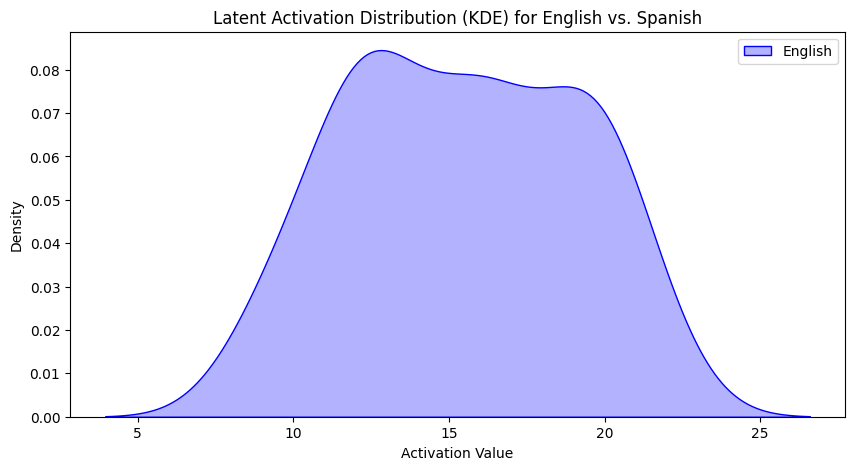

In [75]:
import seaborn as sns

def plot_latent_activation_distributions(activations_A, activations_B, label_A, label_B, plot_title):

    plt.figure(figsize=(10, 5))
    sns.kdeplot(activations_A, fill=True, color="blue", alpha=0.3, label=label_A)
    sns.kdeplot(activations_B, fill=True, color="red", alpha=0.3, label=label_B)
    plt.title(plot_title)
    plt.xlabel("Activation Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()
    
lang_A = "English"
lang_B = "Spanish"
activations_lang_A = compute_latent_activations(model, [sae], data_batches[lang_A], 9, 1205, device=device)
activations_lang_B = compute_latent_activations(model, [sae], data_batches[lang_B], 12, 1205, device=device)
plot_latent_activation_distributions(activations_lang_A, activations_lang_B, lang_A, lang_B, f"Latent Activation Distribution (KDE) for {lang_A} vs. {lang_B}")

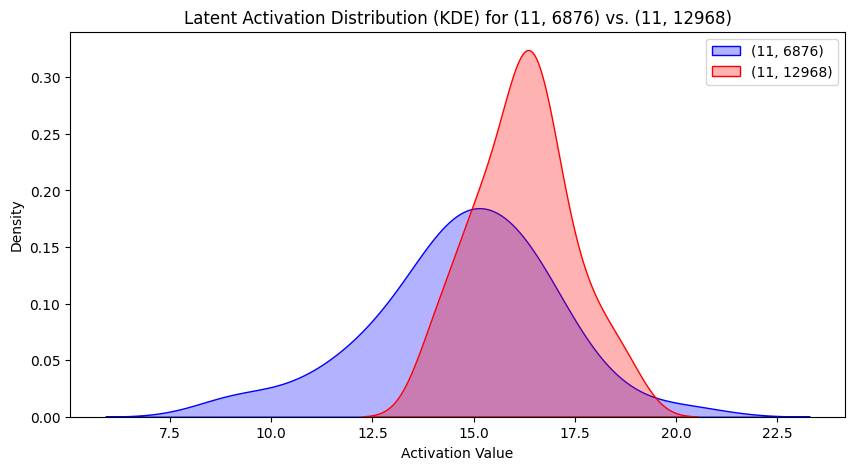

In [ ]:
lang_A = "English"
lang_B = "Spanish"
activations_lang_A = compute_latent_activations(model, [sae], data_batches[lang_A], 11, 6876, device=device)
activations_lang_B = compute_latent_activations(model, [sae], data_batches[lang_A], 11, 12968, device=device)
label_A = "(11, 6876)"
label_B = "(11, 12968)"
plot_title = f"Latent Activation Distribution (KDE) for {label_A} vs. {label_B}"
plot_latent_activation_distributions(activations_lang_A, activations_lang_B, label_A, label_B, plot_title)

# How do copies get chosen?

In [ ]:
# Use bootstrap sampling to get different lists of top latents for each language
# We will try to find the variability

# Exchanging copies

In [24]:
from scipy.spatial.distance import cosine
from scipy.stats import entropy

def swap_latent_activations(
    model,
    saes,
    data,
    seq_pos: int,
    latent_idx_1: int,
    latent_idx_2: int,
):
    """Swap activations of two latents and track shifts in top 5 predicted logits."""
    cleanup_cuda()
    
    # Tokenize input prompts
    toks = model.to_tokens(data["prompts"]).to(device)
    answers = data["answers"]
    labels = torch.Tensor([model.to_single_token(answer) for answer in answers]).int().to(device)
    
    # Get original activations
    hook_sae_acts_post = f"{saes[0].cfg.hook_name}.hook_sae_acts_post"
    orig_logits, orig_cache = model.run_with_cache_with_saes(toks, saes=saes)
    orig_acts = orig_cache[hook_sae_acts_post].detach().clone()  # Shape: [batch_size, seq_len, d_sae]

    # Swap activations at the selected sequence position
    modified_acts = orig_acts.clone()
    modified_acts[:, :, latent_idx_1], modified_acts[:, :, latent_idx_2] = (
        orig_acts[:, :, latent_idx_2].clone(),
        orig_acts[:, :, latent_idx_1].clone()
    )

    # Define a hook to replace activations
    def activation_hook(act, hook):
        if seq_pos < 0:
            act[:, :, latent_idx_1] = modified_acts[:, :, latent_idx_1]
            act[:, :, latent_idx_2] = modified_acts[:, :, latent_idx_2]            
        else:
            act[:, seq_pos, latent_idx_1] = modified_acts[:, seq_pos, latent_idx_1]
            act[:, seq_pos, latent_idx_2] = modified_acts[:, seq_pos, latent_idx_2]
        return act
    
    model.reset_hooks(including_permanent=True)
    model.reset_saes()
    model.add_sae(saes[0])
    model.add_hook(hook_sae_acts_post, activation_hook, "fwd")

    # Re-run model with swapped activations
    swapped_logits = model(toks)

    clear_memory(saes, model)
    model.reset_hooks(including_permanent=True)
    model.reset_saes()

    # Convert to probabilities
    orig_probs = torch.softmax(orig_logits[:, -1, :], dim=-1).detach().cpu().numpy()
    swapped_probs = torch.softmax(swapped_logits[:, -1, :], dim=-1).detach().cpu().numpy()

    # Compute logit shift metrics
    kl_div = np.mean([entropy(orig_probs[i], swapped_probs[i]) for i in range(orig_probs.shape[0])])
    cosine_sim = np.mean([1 - cosine(orig_probs[i], swapped_probs[i]) for i in range(orig_probs.shape[0])])
    l2_norm = np.mean(np.linalg.norm(orig_probs - swapped_probs, axis=1))

    # Find top 5 predicted tokens before and after swap
    top_5_orig = np.argsort(-orig_probs, axis=1)[:, :5]  # Top 5 token indices
    top_5_swapped = np.argsort(-swapped_probs, axis=1)[:, :5]

    # Map token indices to actual token strings (optional, if vocab available)
    def decode_top_tokens(top_indices, probs):
        return [
            [(model.to_string(idx), probs[i, idx]) for idx in top_indices[i]]
            for i in range(probs.shape[0])
        ]

    orig_top_tokens = decode_top_tokens(top_5_orig, orig_probs)
    swapped_top_tokens = decode_top_tokens(top_5_swapped, swapped_probs)

    return {
        "kl_divergence": kl_div,
        "cosine_similarity": cosine_sim,
        "l2_norm": l2_norm,
        "top_5_orig": orig_top_tokens,
        "top_5_swapped": swapped_top_tokens
    }


In [44]:
lang = "Spanish"
results_swap = swap_latent_activations(model, [sae], data_batches[lang], seq_pos=-1, latent_idx_1=2592, latent_idx_2=3986)
swap_idx = -1
print(results_swap["top_5_orig"][swap_idx])
print(results_swap["top_5_swapped"][swap_idx])
print(f"KL divergence:", results_swap["kl_divergence"])
print(f"Cosine similarity:", results_swap["cosine_similarity"])
print(f"L2 Norm:", results_swap["l2_norm"])

[(' Richard', 0.3718224), (' Erica', 0.25429702), (' la', 0.15064962), (' su', 0.069329195), (' los', 0.010672977)]
[(' Erica', 0.4996672), (' Richard', 0.2988747), (' la', 0.06622606), (' su', 0.06032263), (' los', 0.0048070354)]
KL divergence: 0.10400761
Cosine similarity: 0.9836918509306596
L2 Norm: 0.096151575


In [50]:
lang = "French"
results_swap = swap_latent_activations(model, [sae], data_batches[lang], seq_pos=-1, latent_idx_1=6876, latent_idx_2=12968)
swap_idx = -1
print(results_swap["top_5_orig"][swap_idx])
print(results_swap["top_5_swapped"][swap_idx])
print(f"KL divergence:", results_swap["kl_divergence"])
print(f"Cosine similarity:", results_swap["cosine_similarity"])
print(f"L2 Norm:", results_swap["l2_norm"])

[(' Erica', 0.72699416), (' Richard', 0.057610396), (' l', 0.051163867), (' la', 0.040076338), (' son', 0.020224964)]
[(' Erica', 0.7184587), (' Richard', 0.060737167), (' l', 0.05252104), (' la', 0.041235954), (' son', 0.020950764)]
KL divergence: 1.4828845e-05
Cosine similarity: 0.9999927709213134
L2 Norm: 0.00071704364


In [52]:
def zero_ablate_latent(
    model,
    saes,
    data,
    seq_pos: int,
    latent_idx: int,
    device: str = "cuda"
):
    cleanup_cuda()
    
    # Tokenize input prompts
    toks = model.to_tokens(data["prompts"]).to(device)
    answers = data["answers"]
    labels = torch.Tensor([model.to_single_token(answer) for answer in answers]).int().to(device)
    
    # Get original activations
    hook_sae_acts_post = f"{saes[0].cfg.hook_name}.hook_sae_acts_post"
    orig_logits, orig_cache = model.run_with_cache_with_saes(toks, saes=saes)
    orig_acts = orig_cache[hook_sae_acts_post].detach().clone()  # Shape: [batch_size, seq_len, d_sae]

    # Define a hook to replace activations
    def zero_ablation_hook(act, hook):
        if seq_pos < 0:
            act[:, :, latent_idx] = 0.0
        else:
            act[:, seq_pos, latent_idx] = 0.0
        return act
    
    model.reset_hooks(including_permanent=True)
    model.reset_saes()
    model.add_sae(saes[0])
    model.add_hook(hook_sae_acts_post, zero_ablation_hook, "fwd")

    # Re-run model with swapped activations
    swapped_logits = model(toks)

    clear_memory(saes, model)
    model.reset_hooks(including_permanent=True)
    model.reset_saes()

    # Convert to probabilities
    orig_probs = torch.softmax(orig_logits[:, -1, :], dim=-1).detach().cpu().numpy()
    swapped_probs = torch.softmax(swapped_logits[:, -1, :], dim=-1).detach().cpu().numpy()

    # Compute logit shift metrics
    kl_div = np.mean([entropy(orig_probs[i], swapped_probs[i]) for i in range(orig_probs.shape[0])])
    cosine_sim = np.mean([1 - cosine(orig_probs[i], swapped_probs[i]) for i in range(orig_probs.shape[0])])
    l2_norm = np.mean(np.linalg.norm(orig_probs - swapped_probs, axis=1))

    # Find top 5 predicted tokens before and after swap
    top_5_orig = np.argsort(-orig_probs, axis=1)[:, :5]  # Top 5 token indices
    top_5_swapped = np.argsort(-swapped_probs, axis=1)[:, :5]

    # Map token indices to actual token strings (optional, if vocab available)
    def decode_top_tokens(top_indices, probs):
        return [
            [(model.to_string(idx), probs[i, idx]) for idx in top_indices[i]]
            for i in range(probs.shape[0])
        ]

    orig_top_tokens = decode_top_tokens(top_5_orig, orig_probs)
    swapped_top_tokens = decode_top_tokens(top_5_swapped, swapped_probs)

    return {
        "kl_divergence": kl_div,
        "cosine_similarity": cosine_sim,
        "l2_norm": l2_norm,
        "top_5_orig": orig_top_tokens,
        "top_5_swapped": swapped_top_tokens
    }

In [60]:
def compare_copies_zero_ablated(
    model,
    saes: list,
    data: dict,
    seq_pos: int,
    zeroed_latent: int,
    test_latent: int,
) -> np.ndarray:
    

    toks = model.to_tokens(data["prompts"])
    answers = data["answers"]
    labels = torch.Tensor([model.to_single_token(answer) for answer in answers]).int().to(device)

    # We'll assume the relevant activation key is something like "<hook_name>.hook_sae_acts_post"
    # taken from the SAE's configuration. Adapt if your naming differs.
    hook_sae_acts_post = f"{saes[0].cfg.hook_name}.hook_sae_acts_post"

    # Run the model and get the cache
    # (logits, cache) has shape [batch_size, seq_len, d_sae] for the activation at that hook
    orig_logits, orig_cache = model.run_with_cache_with_saes(toks, saes=saes)

    # Extract the activation from the cache
    # `cache[hook_sae_acts_post]` => shape [batch_size, seq_len, d_sae], typically
    orig_acts = orig_cache[hook_sae_acts_post].detach().cpu()

    cleanup_cuda()

    # Define a hook to replace activations
    def zero_ablation_hook(act, hook):
        if seq_pos < 0:
            act[:, :, latent_idx] = 0.0
        else:
            act[:, seq_pos, latent_idx] = 0.0
        return act
    
    model.reset_hooks(including_permanent=True)
    model.reset_saes()
    model.add_sae(saes[0])
    model.add_hook(hook_sae_acts_post, zero_ablation_hook, "fwd")

    ablated_logits, ablated_cache = model.run_with_cache_with_saes(toks, saes=saes)

    ablated_acts = ablated_cache[hook_sae_acts_post].detach().cpu()

    model.reset_hooks(including_permanent=True)
    model.reset_saes()
    cleanup_cuda()

    return orig_acts, ablated_acts

In [72]:
latent_idx = 12968
for lang in ["English", "Spanish", "French"]:
    print(f"{lang}: ablating latent {latent_idx}")
    results_zero = zero_ablate_latent(model, [sae], data_batches[lang], seq_pos=-1, latent_idx=latent_idx)
    print(results_zero["top_5_orig"][-1])
    print(results_zero["top_5_swapped"][-1])
    print(f"KL divergence:", results_zero["kl_divergence"])
    print(f"Cosine similarity:", results_zero["cosine_similarity"])
    print(f"L2 Norm:", results_zero["l2_norm"])
    print("---------------------------------------------------------------------------------------------")

English: ablating latent 12968
[(' Erica', 0.52124435), (' the', 0.19285399), (' Richard', 0.10305162), (' his', 0.05424145), (' a', 0.03678521)]
[(' Erica', 0.49352604), (' the', 0.2005273), (' Richard', 0.11449742), (' his', 0.05953489), (' a', 0.03825598)]
KL divergence: 0.0022546032
Cosine similarity: 0.9990179082384332
L2 Norm: 0.02627247
---------------------------------------------------------------------------------------------
Spanish: ablating latent 12968
[(' Richard', 0.3718224), (' Erica', 0.25429702), (' la', 0.15064962), (' su', 0.069329195), (' los', 0.010672977)]
[(' Richard', 0.46201813), (' Erica', 0.18862315), (' la', 0.13572133), (' su', 0.06798423), (' los', 0.01016385)]
KL divergence: 0.0040506446
Cosine similarity: 0.9976905919716774
L2 Norm: 0.03836674
---------------------------------------------------------------------------------------------
French: ablating latent 12968
[(' Erica', 0.72699416), (' Richard', 0.057610396), (' l', 0.051163867), (' la', 0.04007

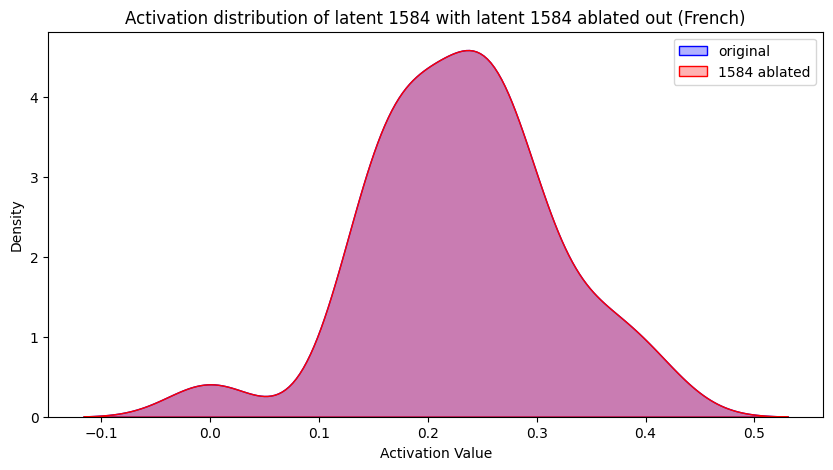

In [96]:
# Get original activations and compare
lang = "French"
zeroed_latent = 1584
test_latent = 1584
orig_acts, ablated_acts = compare_copies_zero_ablated(model, [sae], data_batches[lang], seq_pos=-1, zeroed_latent=zeroed_latent, test_latent=test_latent)
orig_acts = torch.mean(orig_acts[:, :, test_latent], dim=-1)
ablated_acts = torch.mean(ablated_acts[:, :, test_latent], dim=-1)
plot_latent_activation_distributions(orig_acts, ablated_acts, "original", f"{zeroed_latent} ablated", f"Activation distribution of latent {test_latent} with latent {zeroed_latent} ablated out ({lang})")

# Steering with copies

In [ ]:
from functools import partial

saes = [sae]
latent_idx = latent_idx
lang = "English"
clean_tokens = model.to_tokens(data["prompts"])
answers = data["answers"]
labels = torch.Tensor([model.to_single_token(answer) for answer in answers]).int().to(device)

# Range of steering coefficients to sweep over
coeff_values = range(-80, 81, 10)
top_k = 5  # Number of top tokens to track

# Data structure to store top token probabilities for each coefficient
log_probs_data = {}

# Iterate over each steering coefficient
for coeff in coeff_values:
    # Define the steering hook with the current coefficient
    _steering_hook = partial(
        steering_hook,
        sae=saes[0],
        latent_idx=latent_idx,
        steering_coefficient=coeff,
    )
    
    # Add the steering hook to the model
    model.add_hook(saes[0].cfg.hook_name, _steering_hook, "fwd")
    
    # Run the model with no gradient
    with torch.no_grad():
        logits = model(clean_tokens)
    
    # Reset hooks after running
    model.reset_hooks()
    
    # Calculate log probabilities and mean over batch dimension
    log_probs = torch.nn.functional.softmax(logits, dim=-1).mean(dim=0)
    log_probs_last = log_probs[-1, :]  # Log probs of the last token position

    # Get the top 5 tokens and their log probabilities
    top_probs, top_tokens = torch.topk(log_probs_last, top_k)
    
    # Store the token IDs and log probabilities for this coefficient
    log_probs_data[coeff] = {
        "tokens": top_tokens.tolist(),
        "log_probs": top_probs.tolist()
    }
print(log_probs_data)